### Residual lensing amplitude (Alens) by internal delensing as a function of CMB white noise level

In [1]:
# external
import numpy as np
from matplotlib.pyplot import *
# from cmblensplus/wrap/
import basic
import curvedsky as cs
# from cmblensplus/utils/
import plottools as plc

First define parameters

In [2]:
Tcmb  = 2.726e6    # CMB temperature
Lmin, Lmax  = 2, 4096       # maximum multipole of output normalization
rlmin, rlmax = 100, 4096  # CMB multipole range for reconstruction
dlmin, dlmax = 2, 3000    # lensing template
L = np.linspace(0,Lmax,Lmax+1)
Lfac = (L*(L+1.))**2/(2*np.pi)
ac2rad = np.pi/10800.

Load arrays of CMB unlensed and lensed Cls. Unlensed Cls are not used for now. The Cls should not be multiplied by any factors and should not have units.  

In [3]:
# ucl is an array of shape [0:5,0:rlmax+1] and ucl[0,:] = TT, ucl[1,:] = EE, ucl[2,:] = TE, lcl[3,:] = phiphi, lcl[4,:] = Tphi
ucl = basic.aps.read_cambcls('../data/unlensedcls.dat',2,rlmax,5)/Tcmb**2 # TT, EE, TE, pp, Tp
# lcl is an array of shape [0:4,0:rlmax+1] and lcl[0,:] = TT, lcl[1,:] = EE, lcl[2,:] = BB, and lcl[3,:] = TE
lcl = basic.aps.read_cambcls('../data/lensedcls.dat',2,rlmax,4,bb=True)/Tcmb**2 # TT, EE, BB, TE

Loop over sig

In [4]:
sigs = np.array([50.,40.,30.,20.,10.,5.,3.,2.,1.,.5,.3,.1])
theta = 1.
Ag = {}
for i, sig in enumerate(sigs):
    nl  = np.zeros((4,rlmax+1))
    nl[0,:] = .5*(sig*ac2rad/Tcmb)**2*np.exp(L*(L+1.)*(theta*ac2rad)**2/np.log(2.)/8.)
    nl[1,:] = 2*nl[0,:]
    nl[2,:] = 2*nl[0,:]
    ocl = lcl + nl
    Ag[i], __ = cs.norm_quad.qeb_iter(Lmax,rlmax,rlmin,rlmax,rlmin,rlmax,lcl[1,:],ocl[1,:],ocl[2,:],ucl[3,:],iter=50)

Check reconstruction noise

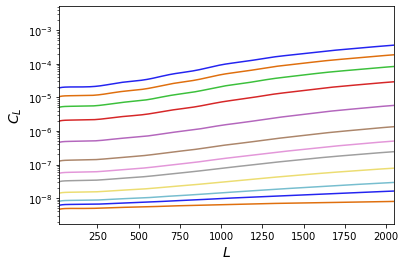

In [5]:
plc.plot_1dstyle(ylog=True)
for i in range(len(sigs)):
    plot(L,L**4*Ag[i],label=str(sigs[i]))

Compute lensing BB as a convolution

In [6]:
bb = basic.delens.lensingbb(dlmax, dlmin, dlmax, lcl[1,:dlmax+1], ucl[3,:dlmax+1])

Compute delensed BB as a convolution

In [7]:
rbb = {}
for i in range(len(sigs)):
    WE = ucl[1,:]/ocl[1,:]
    Wp = ucl[3,:]/(ucl[3,:]+Ag[i])
    rbb[i] = basic.delens.resbb(dlmax, dlmin, dlmax, lcl[1,:dlmax+1], ucl[3,:dlmax+1], WE[:dlmax+1], Wp[:dlmax+1])

/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


Check residual fraction of lensing BB

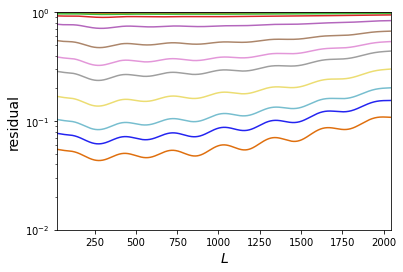

In [8]:
plc.plot_1dstyle(ymin=.01,ymax=1.,ylog=True,ylab='residual')
for i in range(len(sigs)):
    plot(L[2:dlmax+1],rbb[i][2:]/bb[2:])

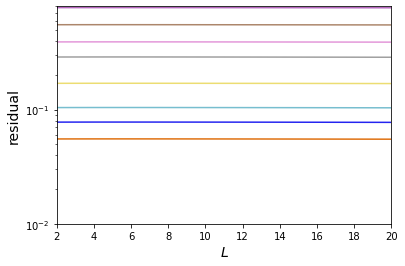

In [9]:
plc.plot_1dstyle(xmin=2,xmax=20,ymin=.01,ymax=.8,ylog=True,ylab='residual')
for i in range(len(sigs)):
    plot(L[2:dlmax+1],rbb[i][2:]/bb[2:])

Compute Alens as an average between ell=2 and 20

In [10]:
Alens = np.zeros(len(sigs))
for i in range(len(sigs)):
    Alens_ell = rbb[i][2:21]/bb[2:21]
    Alens[i] = np.mean(Alens_ell)

In [ ]:
plc.plot_1dstyle(xmin=sigs[-1],xmax=sigs[0],ymin=.1,ymax=1.,xlog=True,xlab=r'$\sigma_P$',ylab=r'$A_{\rm lens}$')
plot(sigs,Alens)

In [ ]:
np.savetxt('Alens-sigma.dat',np.array((sigs,Alens)).T)